In [1]:
import inflection
import math
import time
import random
import pickle
import warnings

import seaborn  as sns
import numpy    as np
import pandas   as pd
import xgboost  as xgb

from IPython.display       import Image
from IPython.core.display  import HTML
from datetime              import datetime,timedelta
from tabulate              import tabulate
from scipy                 import stats
from sklearn.preprocessing import RobustScaler,MinMaxScaler,LabelEncoder
from boruta                import BorutaPy
from sklearn.ensemble      import RandomForestRegressor
from sklearn.metrics       import mean_absolute_error,mean_squared_error
from sklearn.linear_model  import LinearRegression,Lasso
from flask                 import Flask,request,Response

from matplotlib            import pyplot as plt

warnings.filterwarnings( 'ignore' )

In [2]:
def jupyter_settings():
    """Definições padrões setadas para o uso o Jupyter Notebook."""
    %matplotlib inline
    %pylab inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    sns.set()
    
jupyter_settings()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


# <font color=blue>Predições de Vendas das Lojas ROSSMANN</font>

# Agenda

1. Contexto
2. Desafio
3. Desenvolvimendo da Solução
4. Conclusão & Demonstração
5. Próximos Passos

# <font color=blue>1. Contexto</font>

- Reunião Mensal de Resultados
- CFO pediu uma Precisão de Vendas das Próximas 6 Semenas de cada Loja

# <font color=blue>2. Desafio</font>

## Problema
- Definição do orçamento para a Reforma das Lojas

## Causa
- Predição de Vendas Atual apresentava muita Divergência
- Processo de Predição de Vendas é baseado e Experiências Passadas.
- Todas a Previsão de Vendas é feita Manutalmente pelas 1.115 Lojas da Rossmann.
- A visualização das Vendas é Limitada ao Computador.

# Solução
- Usar Machine Learning para realizar a Previsão de Vendas de Todas as Lojas
- Visualização das Predições de Vendas poderão ser feitas pelo Smartphone

# <font color=blue>3. Desenvolvimendo da Solução</font>

# Descrição dos dados

In [10]:
#Noção da dimensão do dataset
print(f'Número de linhas - {df1.shape[0]}')
print(f'Número de colunas - {df1.shape[1]}')

Número de linhas - 1017209
Número de colunas - 18


# Descriptive Statistical

In [16]:
# Ter uma noção geral das métricas do negócio
# Central Tendency = mean, median
ct1 = pd.DataFrame(num_atrr.apply(np.mean)).T
ct2 = pd.DataFrame(num_atrr.apply(np.median)).T

# Dispersion = std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_atrr.apply(np.std)).T
d2 = pd.DataFrame(num_atrr.apply(np.min)).T
d3 = pd.DataFrame(num_atrr.apply(np.max)).T
d4 = pd.DataFrame(num_atrr.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_atrr.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_atrr.apply(lambda x: x.kurtosis())).T

#Concaterando as métricas
m = pd.concat([d2,d3,d4,ct1,ct2,d1,d5,d6]).T.reset_index()
m.columns = ['attributes','min','max','range','mean','median','std','skew','kustosis']
m

,attributes,min,max,range,mean,median,std,skew,kustosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


# Mapa mental de Hipóteses

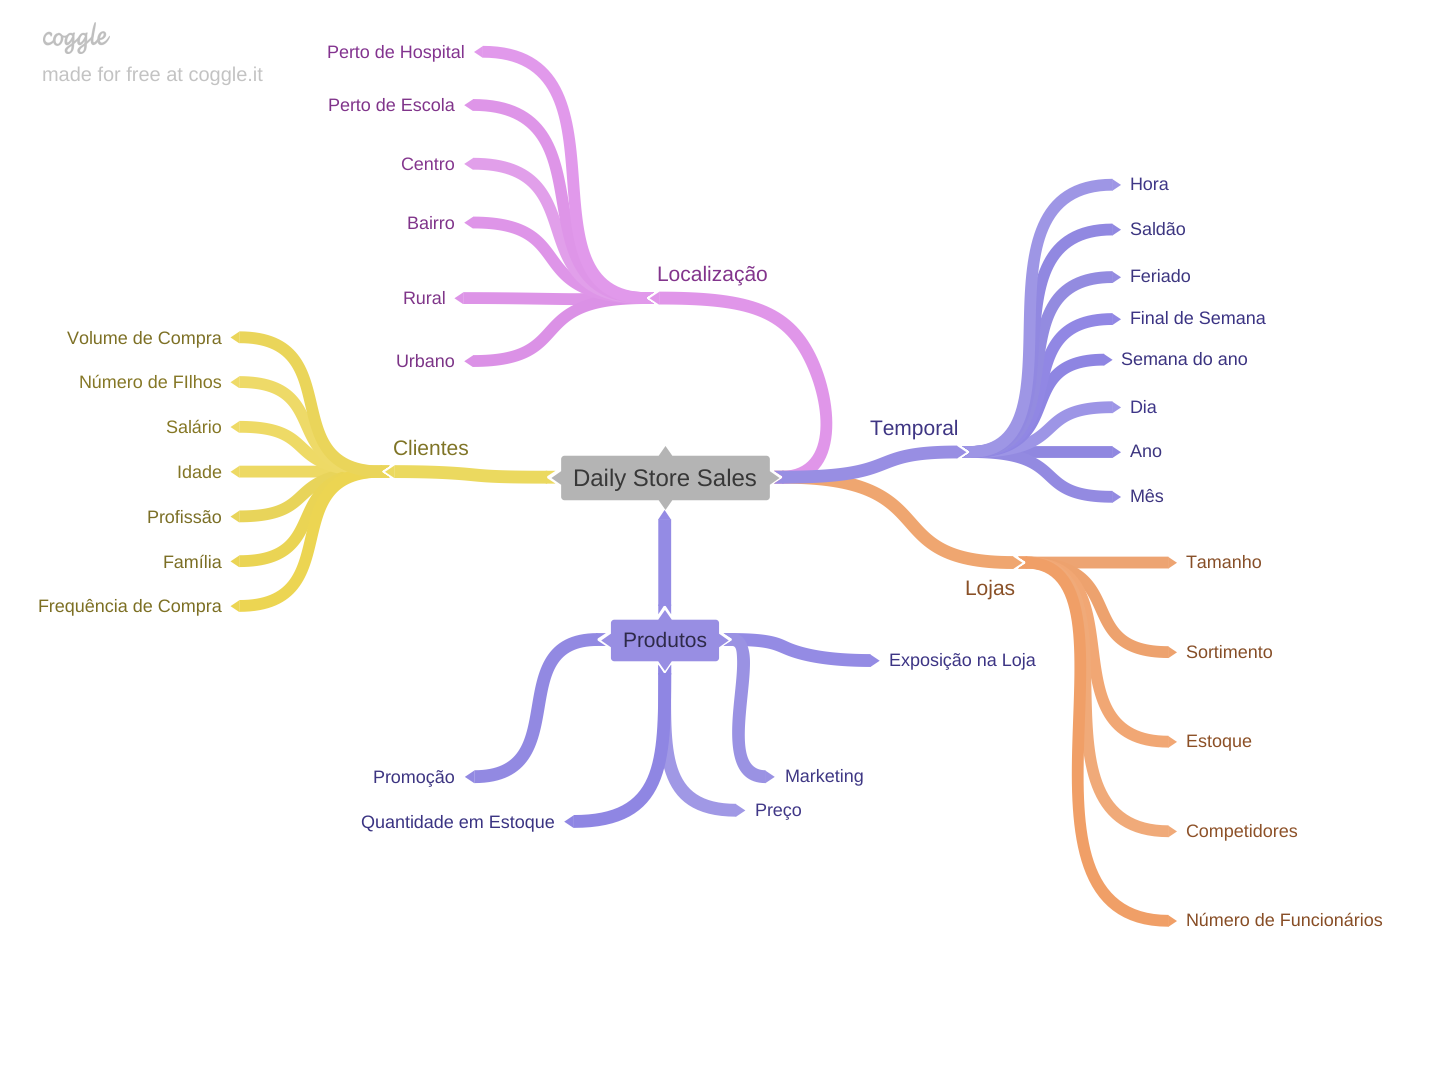

In [21]:
Image('img/mindmap_hipoteses.png')

# Hipóteses da Análise Exploratória

**1.** Lojas com maior sortimentos deveriam vender mais.

**2.** Lojas com competidores mais próximos deveriam vender menos.

**3.** Lojas com competidores à mais tempo deveriam vendem mais.

**4.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**5.** Lojas com mais dias de promoção deveriam vender mais.

**6.** Lojas com mais promoções consecutivas deveriam vender mais.

**7.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**8.** Lojas deveriam vender mais ao longo dos anos.

**9.** Lojas deveriam vender mais no segundo semestre do ano.

**10.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**11.** Lojas deveriam vender menos aos finais de semana.

**12.** Lojas deveriam vender menos durante os feriados escolares.

# Análise Exploratória dos Dados

# Variável Resposta

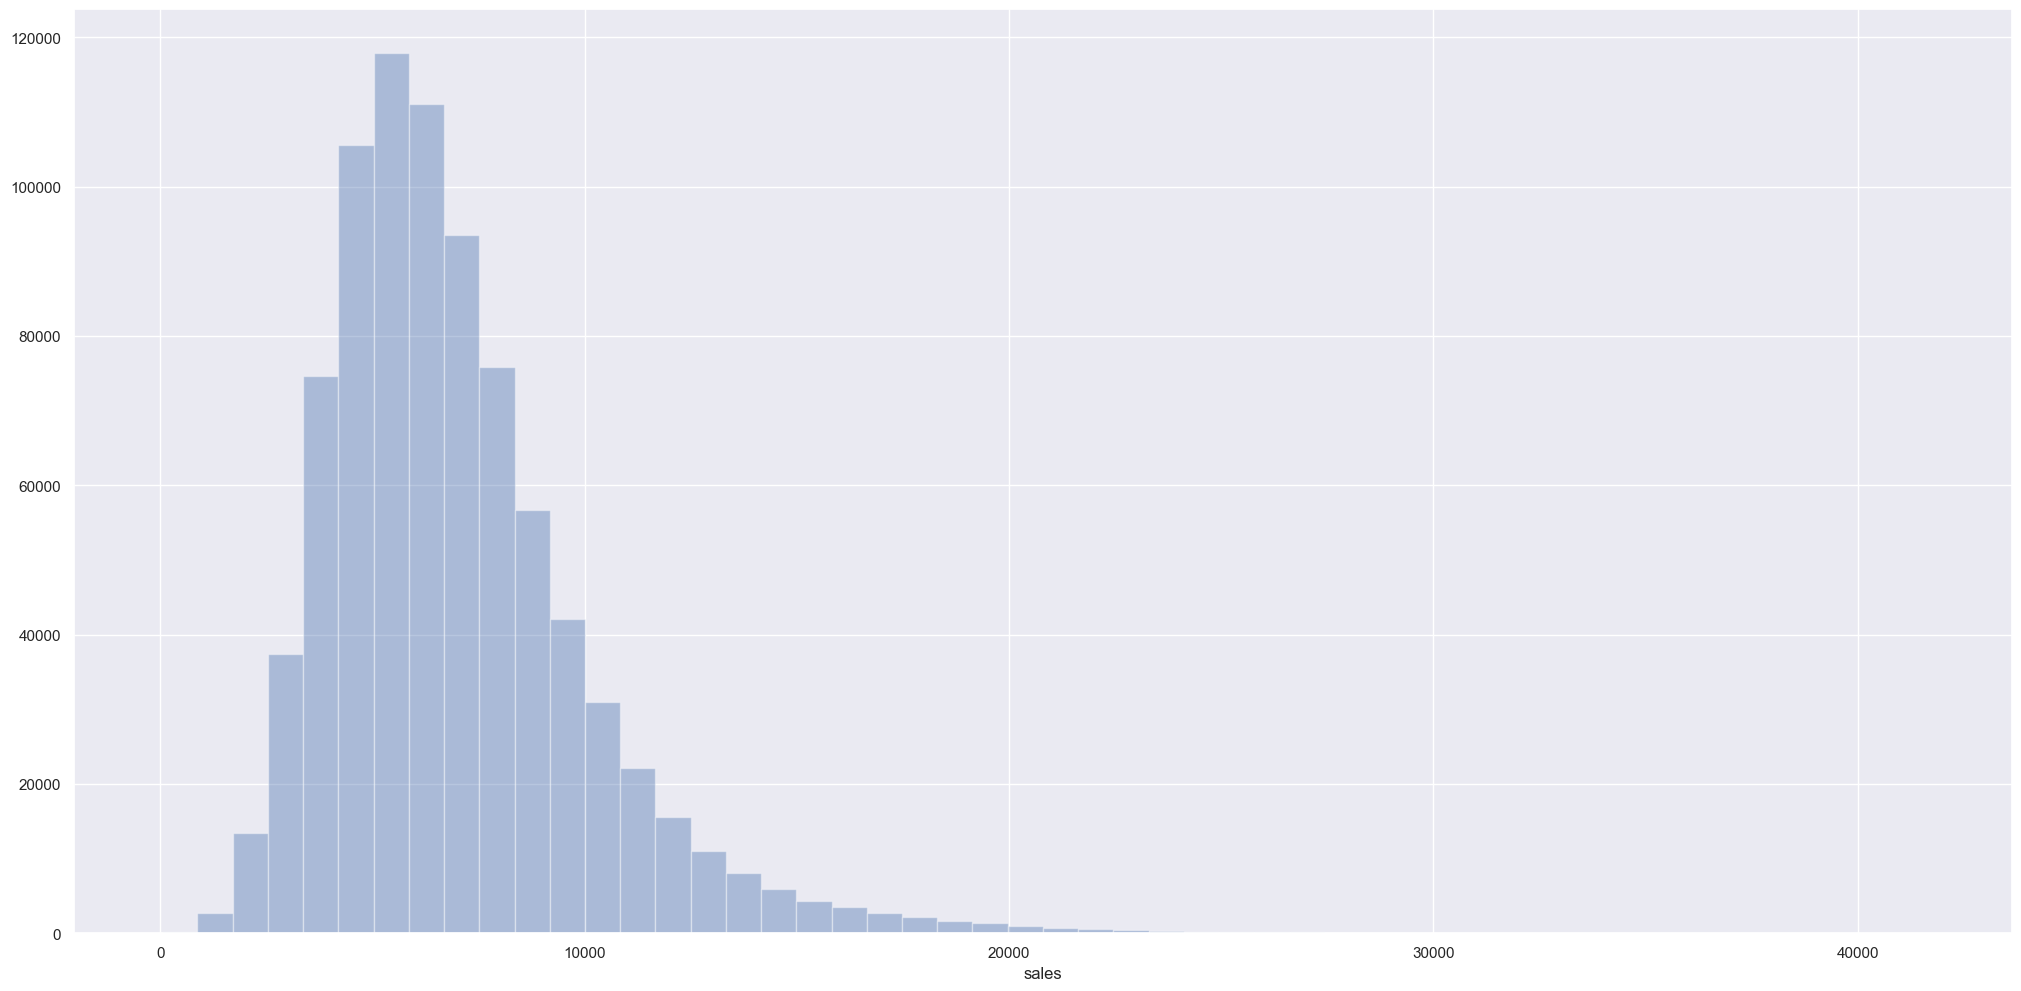

In [29]:
#Plot da densidade de distribuição do fenômeno que queremos prever
sns.distplot(df4['sales'],kde=False);

# Variáveis Numéricas

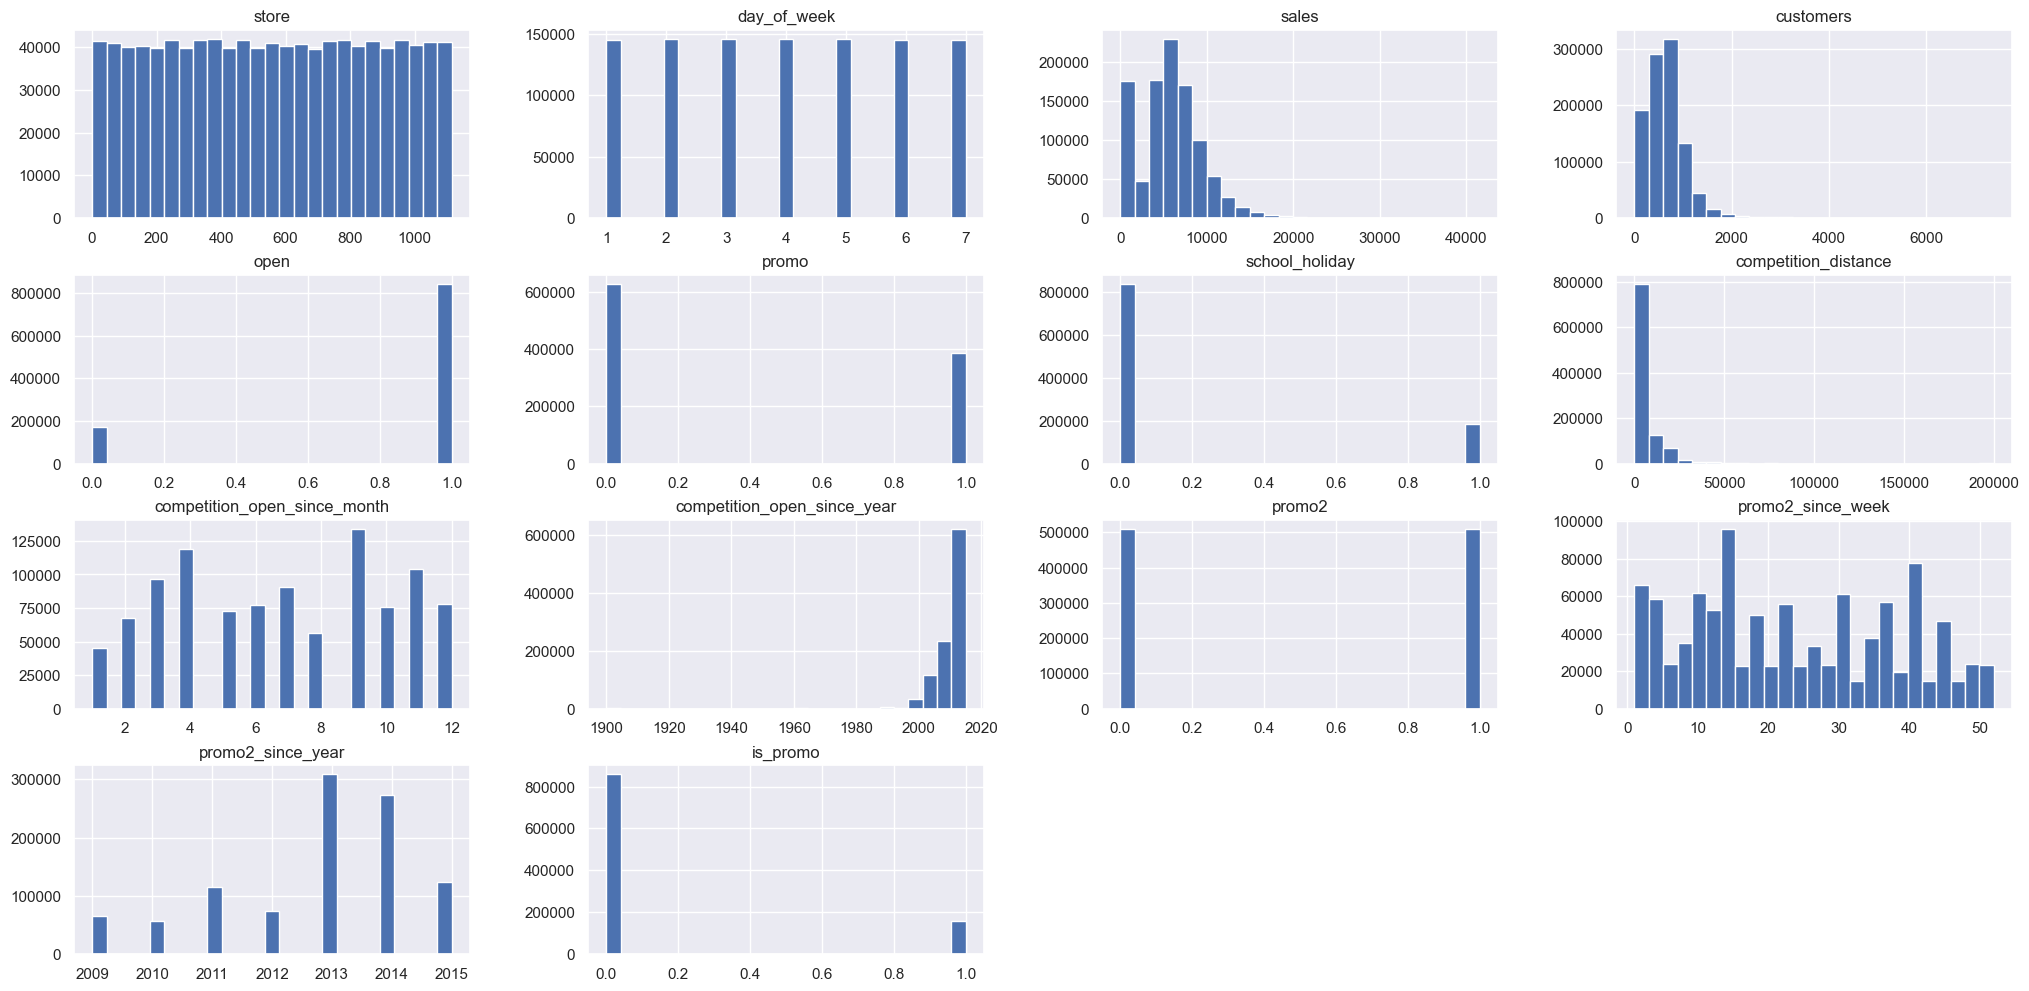

In [30]:
#Mostra a contagem das variáveis númericas, quantas vezes elas aparecem
#Com isso analisamos o compotamento das variáveis e o range das mesmas para tentar entender melhor os dados
num_atrr.hist(bins = 25);

# Variáveis Categóricas

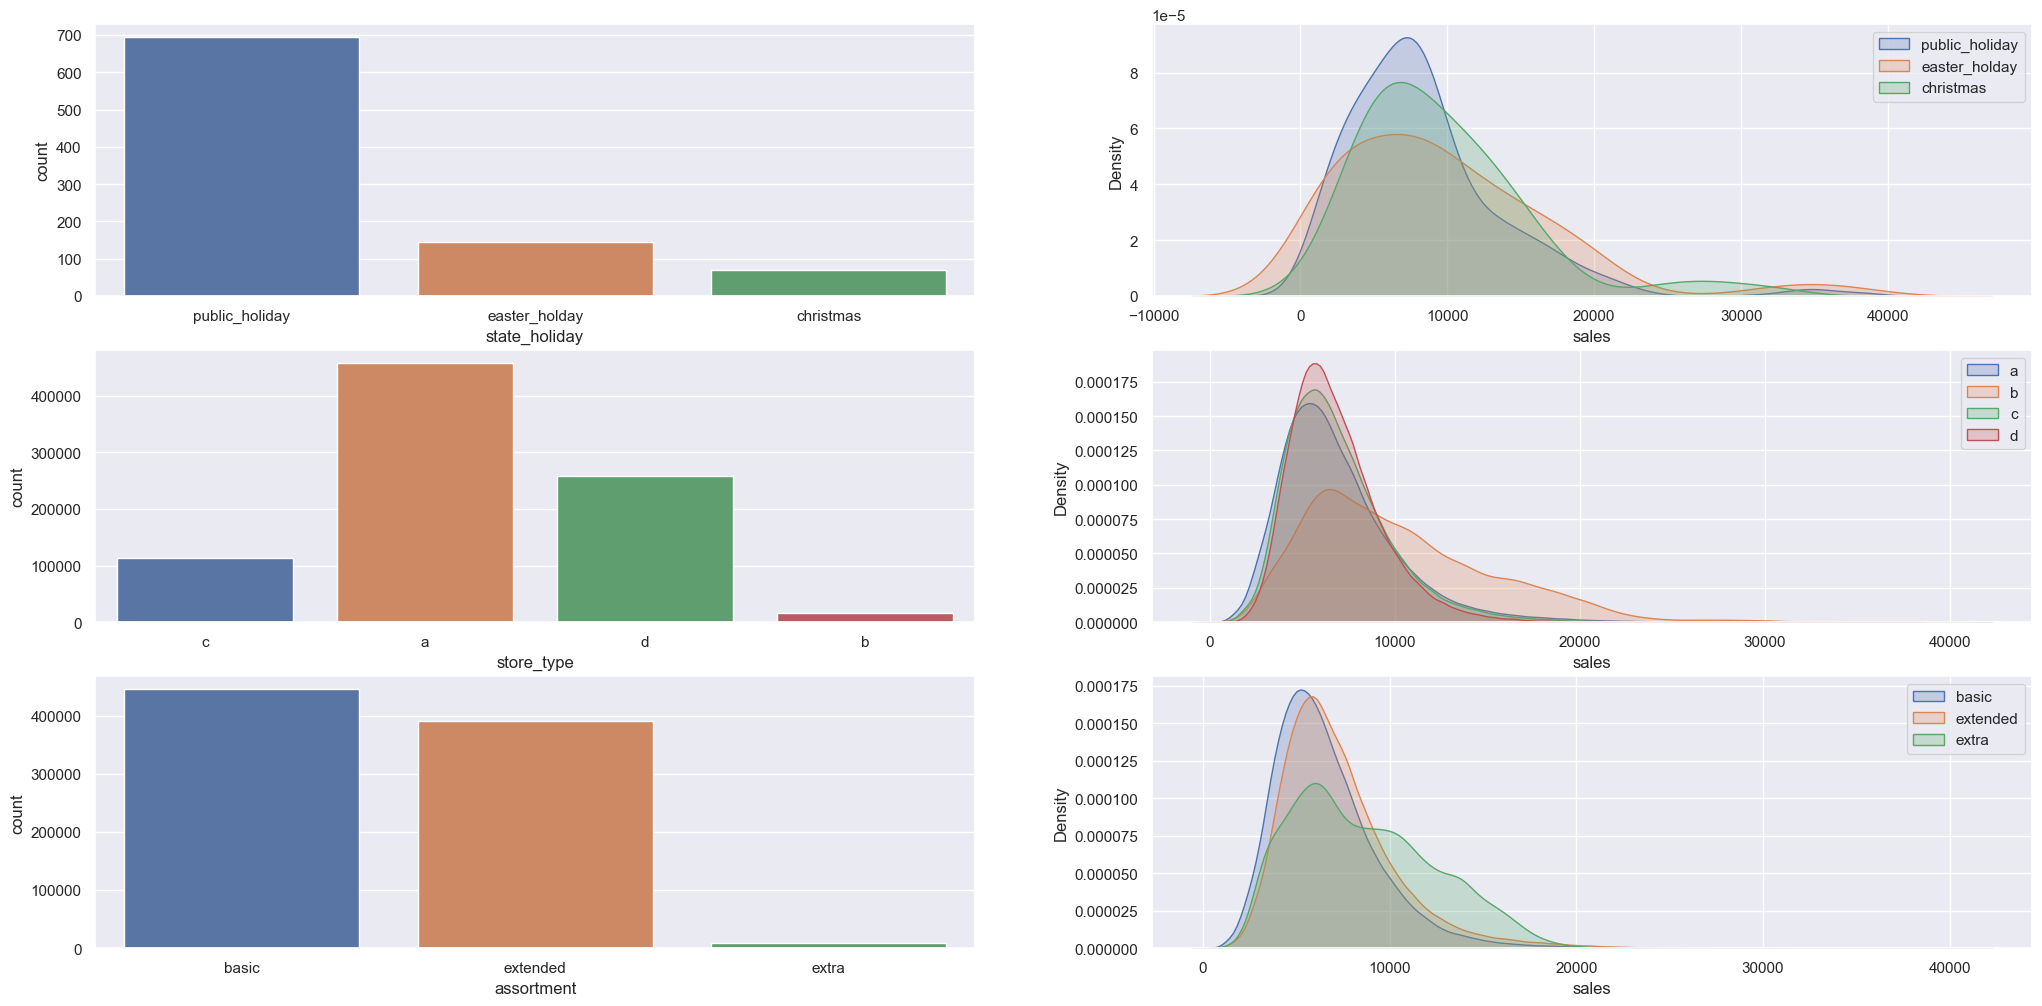

In [31]:
#Mostra a contagem das variáveis categóricas, quantas vezes elas aparecem e compara a densidade de vendas entre elas
#state_holiday
plt.subplot(3,2,1) #Contagem
aux_plot = df4[df4['state_holiday'] != 'regular_day'] #A maioria dos dias é regular_day, então tiramos ele para ter uma ideia das outras
sns.countplot( data=aux_plot['state_holiday'].reset_index(),x='state_holiday' );

plt.subplot(3,2,2) #Densidade das vendas com relação à variável
sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday']['sales'],label='public_holiday',shade=True);
sns.kdeplot(df4[df4['state_holiday'] == 'easter_holday']['sales'],label='easter_holday',shade=True);
sns.kdeplot(df4[df4['state_holiday'] == 'christmas']['sales'],label='christmas',shade=True);
plt.legend();

#store_type
plt.subplot(3,2,3)  #Contagem
sns.countplot( data=df4['store_type'].reset_index(),x='store_type' );

plt.subplot(3,2,4) #Densidade das vendas com relação à variável
sns.kdeplot(df4[df4['store_type'] == 'a']['sales'],label='a',shade=True);
sns.kdeplot(df4[df4['store_type'] == 'b']['sales'],label='b',shade=True);
sns.kdeplot(df4[df4['store_type'] == 'c']['sales'],label='c',shade=True);
sns.kdeplot(df4[df4['store_type'] == 'd']['sales'],label='d',shade=True);
plt.legend();

#assortment
plt.subplot(3,2,5)  #Contagem
sns.countplot( data=df4['assortment'].reset_index(),x='assortment' );

plt.subplot(3,2,6) #Densidade das vendas com relação à variável
sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'],label='basic',shade=True);
sns.kdeplot(df4[df4['assortment'] == 'extended']['sales'],label='extended',shade=True);
sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'],label='extra',shade=True);
plt.legend();

# Validação das Hipóteses

### **H2.** Lojas com competidores mais próximos deveriam vender menos.
**FALSO** Lojas com COMPETIDORES MAIS PRÓXIMOS vendem MAIS

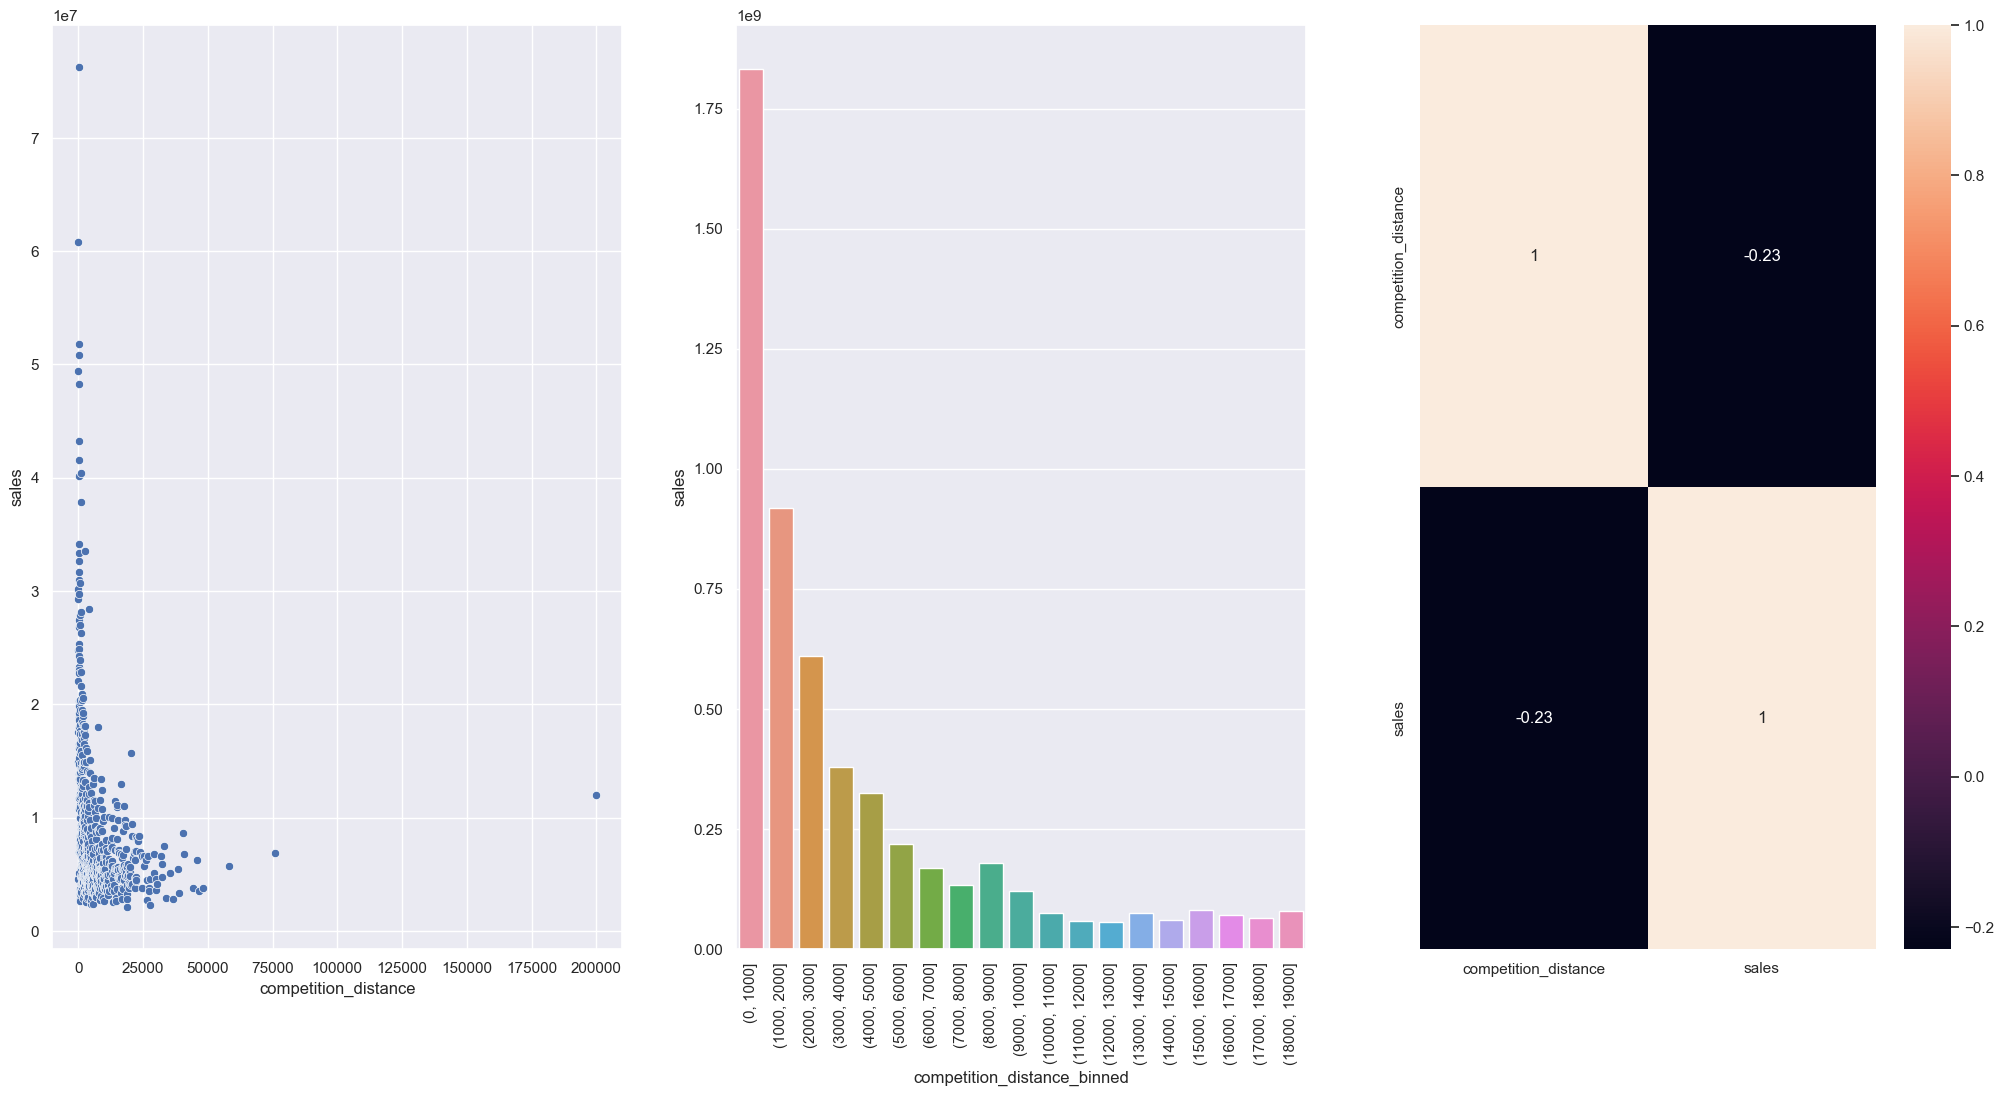

In [33]:
#bin - grupos de valores
aux_1 = df4[['competition_distance','sales']].groupby('competition_distance').sum().reset_index()
plt.subplot(1,3,1)
sns.scatterplot(x='competition_distance',y='sales',data=aux_1);

#Vamos agrupar os resultados em grupos definidos pelos bins para melhorar a vizualização do gráfico
bins = list(np.arange(0,20000,1000))
#Cria os intervalos através de uma array e identifica cada valor em seu intervalo
#Coloca por exemplo, loja com competidores entre 0 e 1000 KM no mesmo intervalo e assim por diante
aux_1['competition_distance_binned'] = pd.cut(aux_1['competition_distance'],bins=bins)
aux_2 = aux_1[['competition_distance_binned','sales']].groupby('competition_distance_binned').sum().reset_index()
plt.subplot(1,3,2)
sns.barplot(x='competition_distance_binned',y='sales',data=aux_2);
plt.xticks(rotation=90); #Roda os rótulos do eixo x

#O heatmap mede a correlação entre as variáveis que vai de 1 até -1
#Como é -0.23,diz que quanto mais distante o concorrente está, menor a quantidade de vendas
plt.subplot(1,3,3)
x = sns.heatmap( aux_1[['competition_distance','sales']].corr( method='pearson' ), annot=True );

#Quanto mais próximo ao competidor, maior as vendas.

### **H7.** Lojas abertas durante o feriado de Natal deveriam vender mais.
**FALSO** Lojas abertas durante o feriado de Natal vendem MENOS.

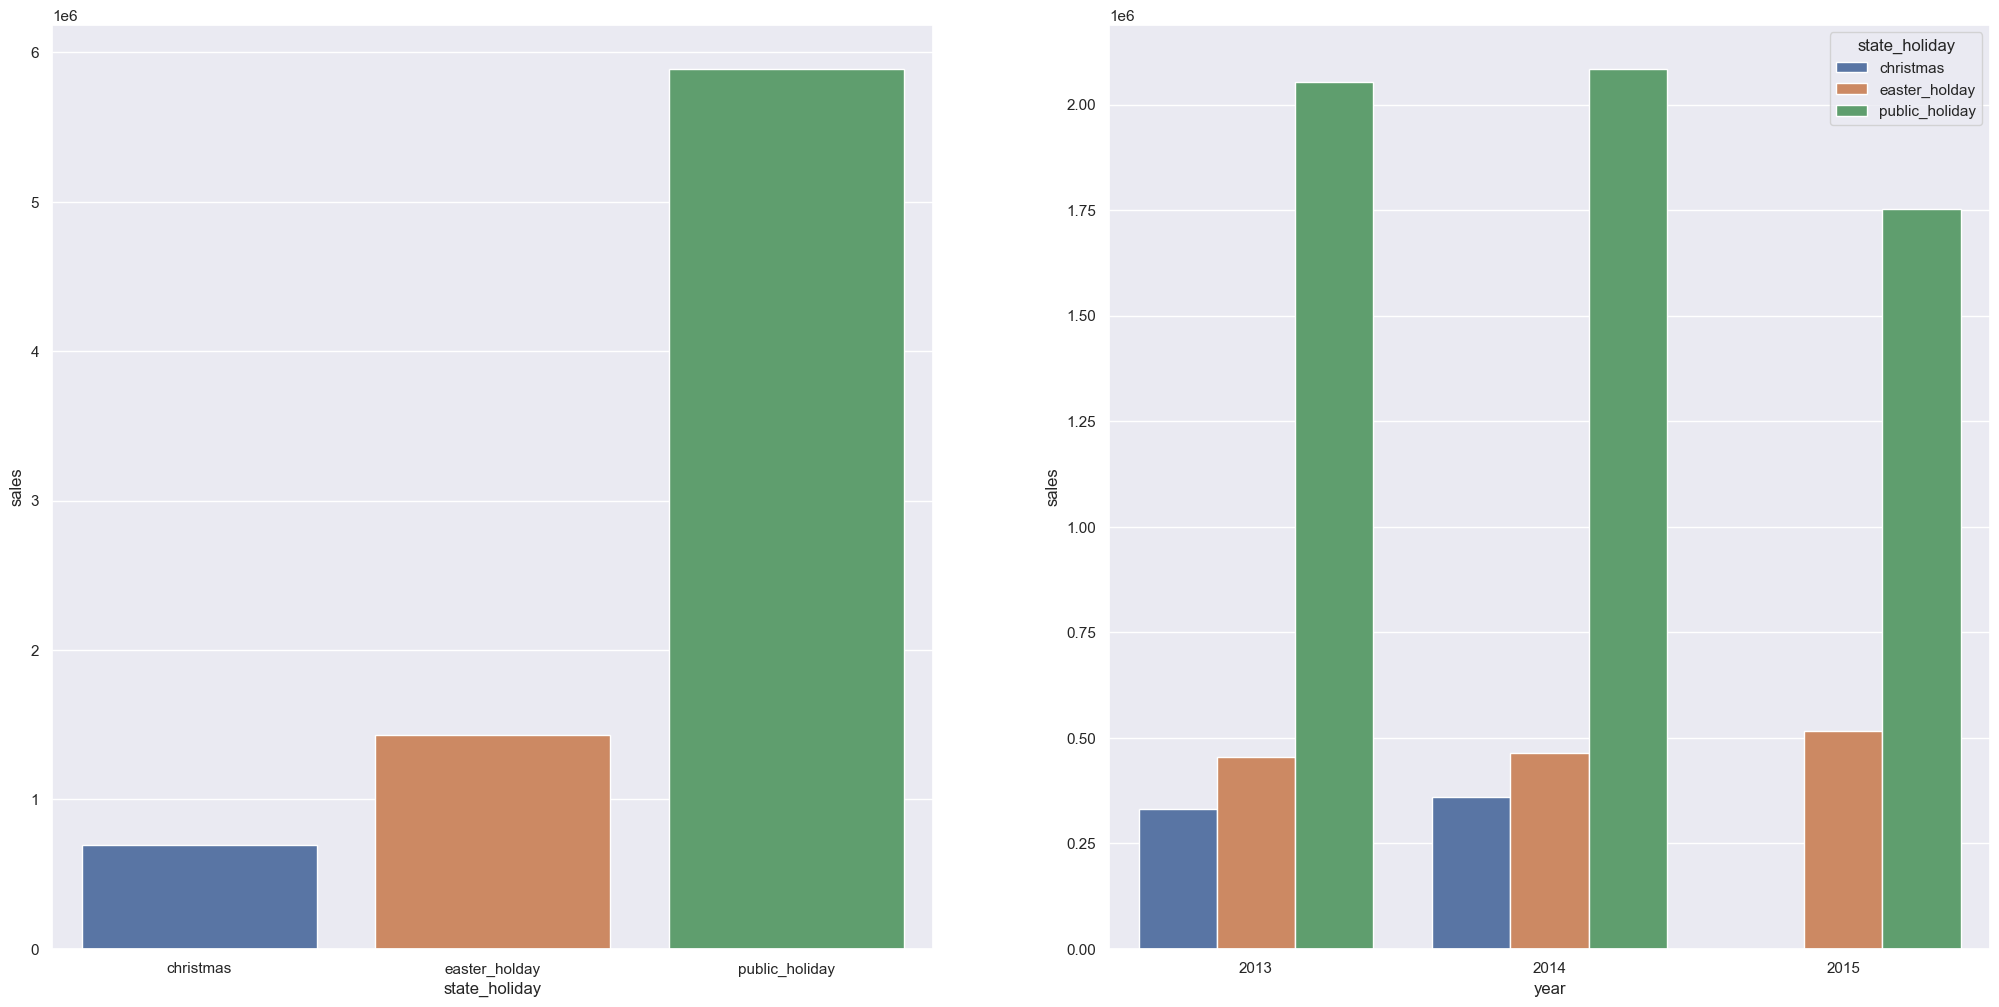

In [81]:
aux = df4[df4['state_holiday'] != 'regular_day']
aux_1 = aux[['state_holiday','sales']].groupby('state_holiday').sum().reset_index()
plt.subplot(1,2,1)
sns.barplot(x='state_holiday',y='sales',data=aux_1);

#Venda no Natal ao longo do tempo, agrupando e somando as vendas por ano e feriado
aux_2 = aux[['year','state_holiday','sales']].groupby(['year','state_holiday']).sum().reset_index()
plt.subplot(1,2,2)
sns.barplot(x='year',y='sales',hue='state_holiday',data=aux_2);

#Lojas abertas durante o Natal vendem menos que os outros feriados
#Passando pelos anos, vemos que em todos os anos, no Natal vende menos que os outros feriados

### **H10.** Lojas deveriam vender mais depois do dia 10 de cada mês.
**VERDADEIRO** Lojas vendem MAIS depois do dia 10 de cada mês

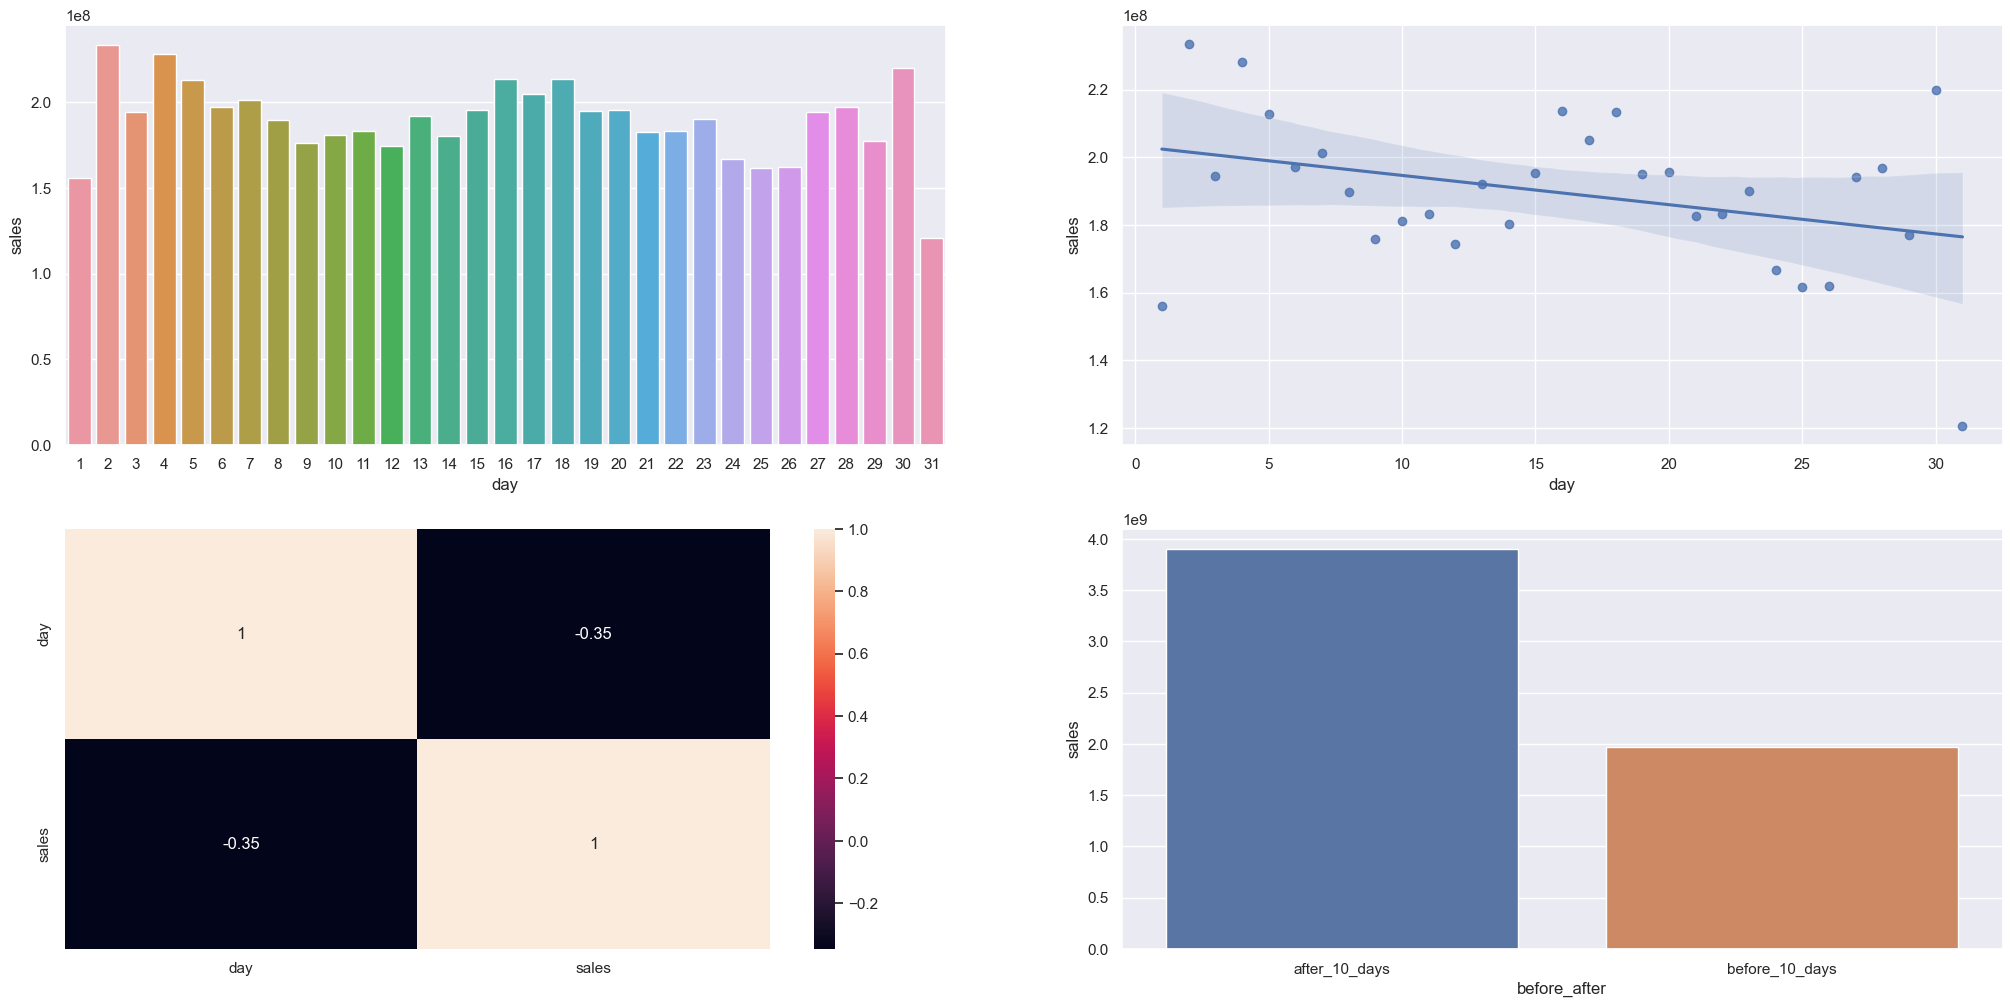

In [84]:
#Soma das vendas no decorrer dos dias
aux_1 = df4[['day','sales']].groupby('day').sum().reset_index()
plt.subplot(2,2,1)
sns.barplot(x='day',y='sales',data=aux_1);

plt.subplot(2,2,2)
sns.regplot(x='day',y='sales',data=aux_1);

plt.subplot(2,2,3)
x = sns.heatmap( aux_1[['day','sales']].corr( method='pearson' ), annot=True );

aux_1['before_after'] = aux_1['day'].apply(lambda x: 'before_10_days' if x <= 10 else 'after_10_days')
aux_2 = aux_1[['before_after','sales']].groupby('before_after').sum().reset_index()
plt.subplot(2,2,4)
sns.barplot(x='before_after',y='sales',data=aux_2);

#Com o passar dos dias do mês as vendas caem
#Correlação média, e com tendência negativa
#As lojas vendem mais depois do dia 10, até porque o período de tempo é maior

# Resumo das Hipóteses

In [88]:
#Resumo um geral da relevância das hipóteses para o modelo a partir da análise exploratória de dados bivariada.
tab =[['Hipoteses', 'Conclusao', 'Relevancia'],
['H1', 'Falsa', 'Baixa'],
['H2', 'Falsa', 'Media'],
['H3', 'Falsa', 'Media'],
['H4', 'Falsa', 'Baixa'],
['H5', '-', '-'],
['H6', 'Falsa', 'Baixa'],
['H7', 'Falsa', 'Media'],
['H8', 'Falsa', 'Alta'],
['H9', 'Falsa', 'Alta'],
['H10', 'Verdadeira', 'Alta'],
['H11', 'Verdadeira', 'Alta'],
['H12', 'Verdadeira', 'Baixa'],
]
print( tabulate( tab, headers='firstrow' ) )

Hipoteses    Conclusao    Relevancia
-----------  -----------  ------------
H1           Falsa        Baixa
H2           Falsa        Media
H3           Falsa        Media
H4           Falsa        Baixa
H5           -            -
H6           Falsa        Baixa
H7           Falsa        Media
H8           Falsa        Alta
H9           Falsa        Alta
H10          Verdadeira   Alta
H11          Verdadeira   Alta
H12          Verdadeira   Baixa


# Análise Multivariada

# Atributos Numéricos

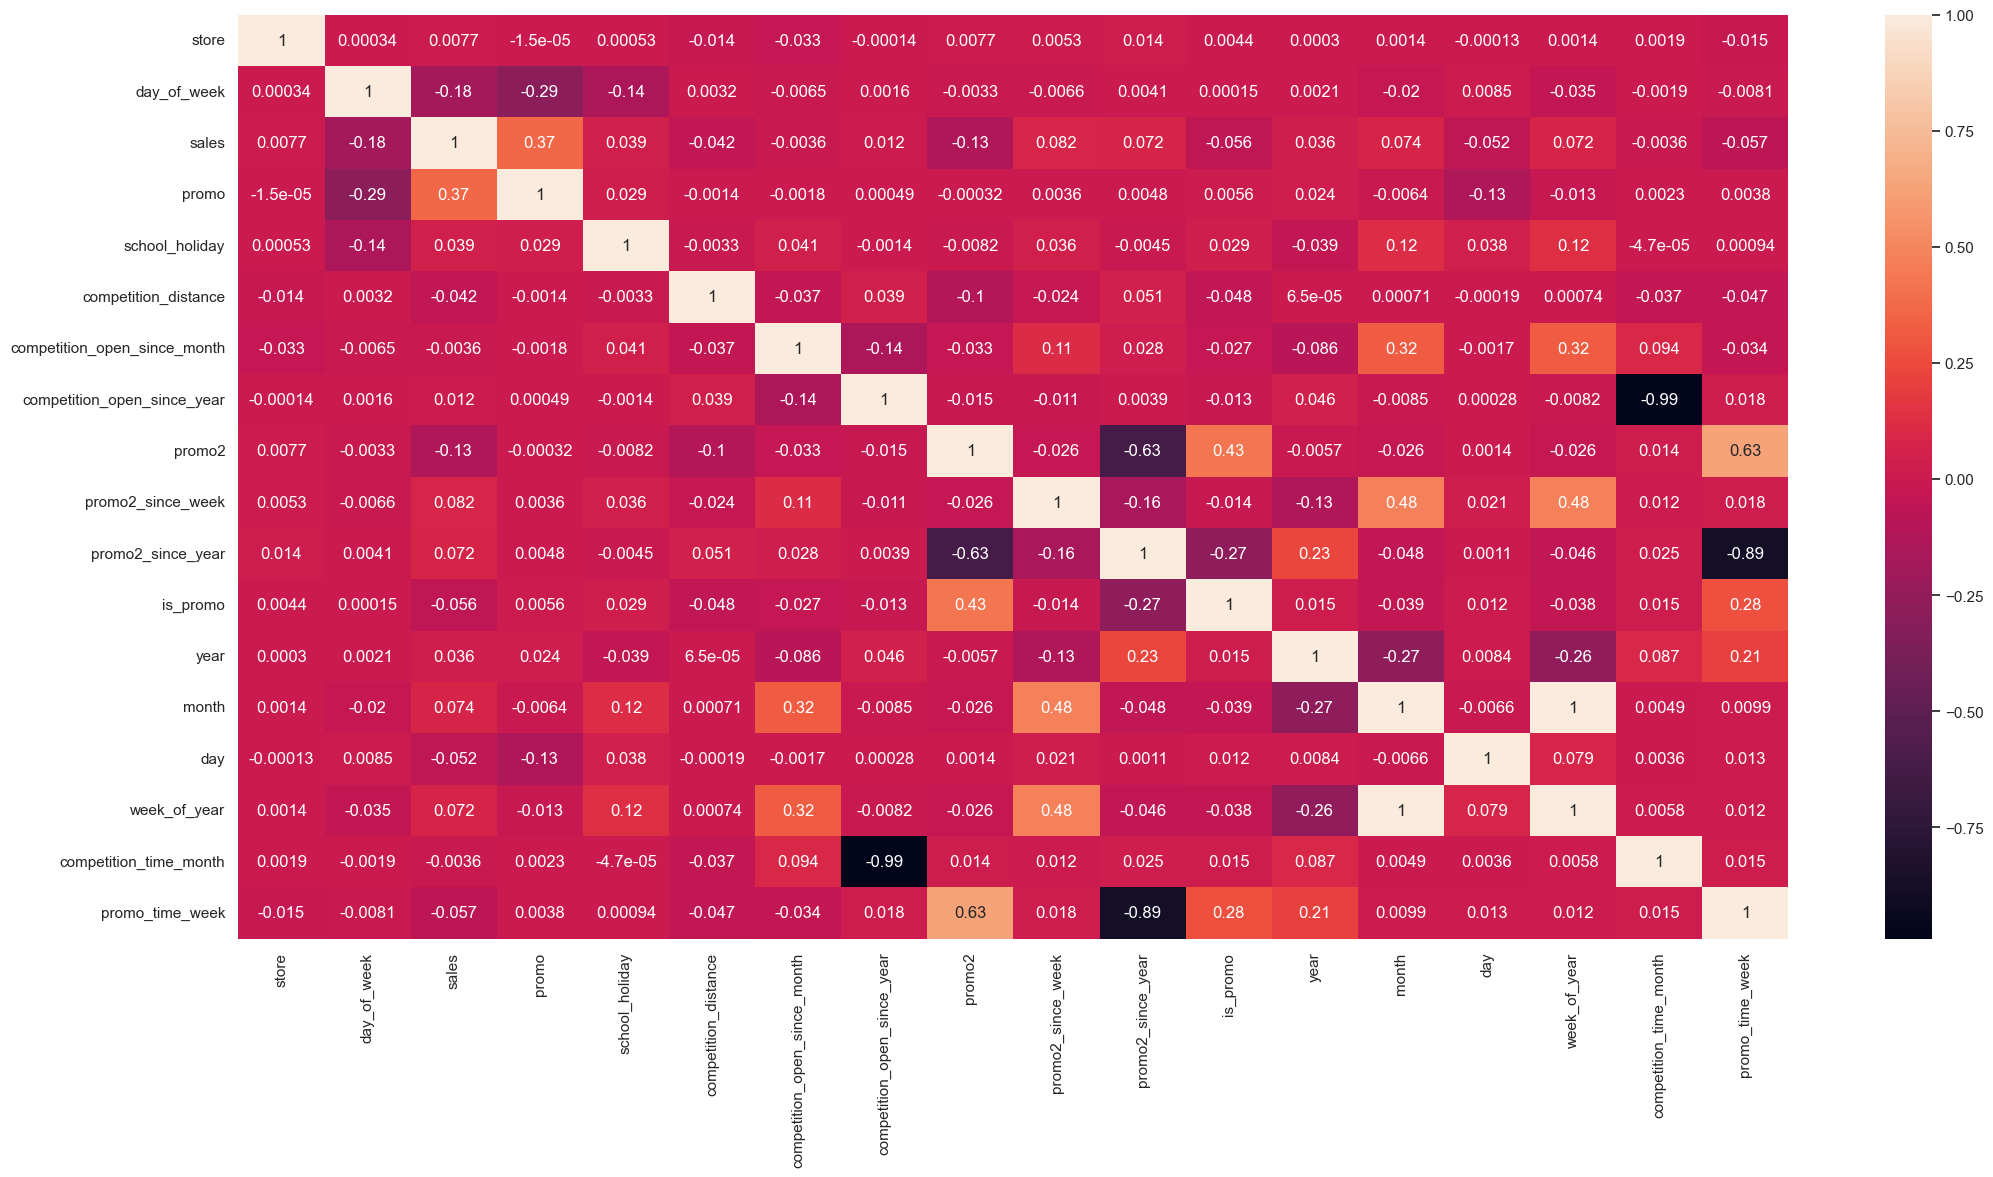

In [92]:
#Vemos a correlação das variáveis numéricas entre elas mesmas
correlation = num_atrr.corr(method='pearson')
sns.heatmap( correlation, annot=True );

#Correlação das variáveis com ela mesmo é sempre 1
#Interessante focar na correlação dessas variáveis com o fenômenos que buscamos - sales

# Atributos Categóricos

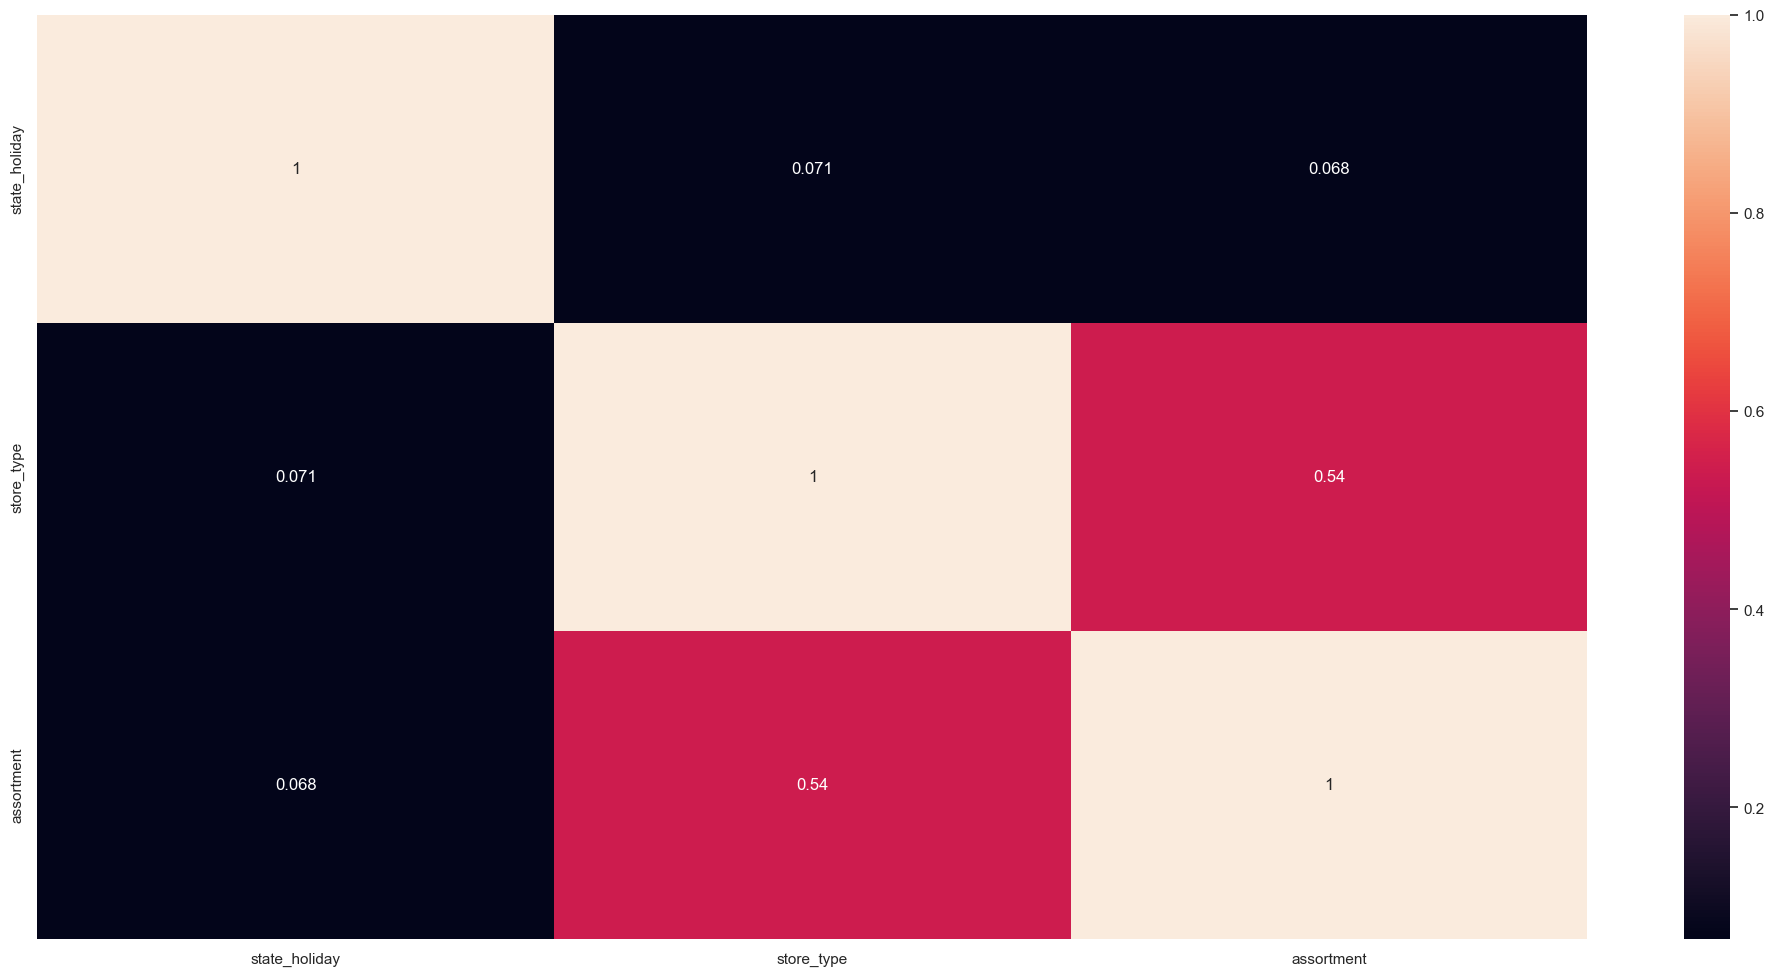

In [93]:
#Criando a relação entre as variáveis categóricas
#Cálculos do Cramer's V
a1 = cramer_v(cat_atrr['state_holiday'],cat_atrr['state_holiday'])
a2 = cramer_v(cat_atrr['state_holiday'],cat_atrr['store_type'])
a3 = cramer_v(cat_atrr['state_holiday'],cat_atrr['assortment'])

a4 = cramer_v(cat_atrr['store_type'],cat_atrr['state_holiday'])
a5 = cramer_v(cat_atrr['store_type'],cat_atrr['store_type'])
a6 = cramer_v(cat_atrr['store_type'],cat_atrr['assortment'])

a7 = cramer_v(cat_atrr['assortment'],cat_atrr['state_holiday'])
a8 = cramer_v(cat_atrr['assortment'],cat_atrr['store_type'])
a9 = cramer_v(cat_atrr['assortment'],cat_atrr['assortment'])

#Dataset final entre as relações das variáveis categóricas
d = pd.DataFrame({'state_holiday':[a1,a2,a3],
              'store_type':[a4,a5,a6],
              'assortment':[a7,a8,a9]})

d = d.set_index(d.columns)
sns.heatmap(d,annot=True);

#Assortment com relação alta com store_type, quanto maior o tipo da loja, mais produtos posso ter.

# Modelo de Machine Learning
# Comparação dos Modelos

In [207]:
modeling_result = pd.concat([lr_result_cv,lrr_result_cv,rf_result_cv,xgb_result_cv])
modeling_result.sort_values('RSME CV')

,Model Name,MAE CV,MAPE CV,RSME CV
0,Random Forest Regressor,843.22 +/- 223.13,0.12 +/- 0.02,1267.99 +/- 328.1
0,XGBoost Regressor,1122.76 +/- 212.97,0.15 +/- 0.02,1622.46 +/- 317.51
0,Linear Regression,2081.69 +/- 295.46,0.3 +/- 0.02,2952.42 +/- 468.15
0,Lasso,2116.64 +/- 341.57,0.29 +/- 0.01,3057.93 +/- 504.72


# <font color=blue>4. Conclusão & Demonstração</font>

# Tradução e interpretação do erro

# Bussiness Performance

In [121]:
#Lojas com maior valor de MAPE, com erros percentuais muito grandes
df92.sort_values('MAPE',ascending=False).head()

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
291,292,107838.242188,104487.621235,111188.863140,3350.620952,0.582583
908,909,233397.484375,225597.388905,241197.579845,7800.095470,0.526004
875,876,196217.312500,192237.595777,200197.029223,3979.716723,0.310853
674,675,159726.031250,158857.975474,160594.087026,868.055776,0.276710
169,170,187639.765625,186650.283183,188629.248067,989.482442,0.250300


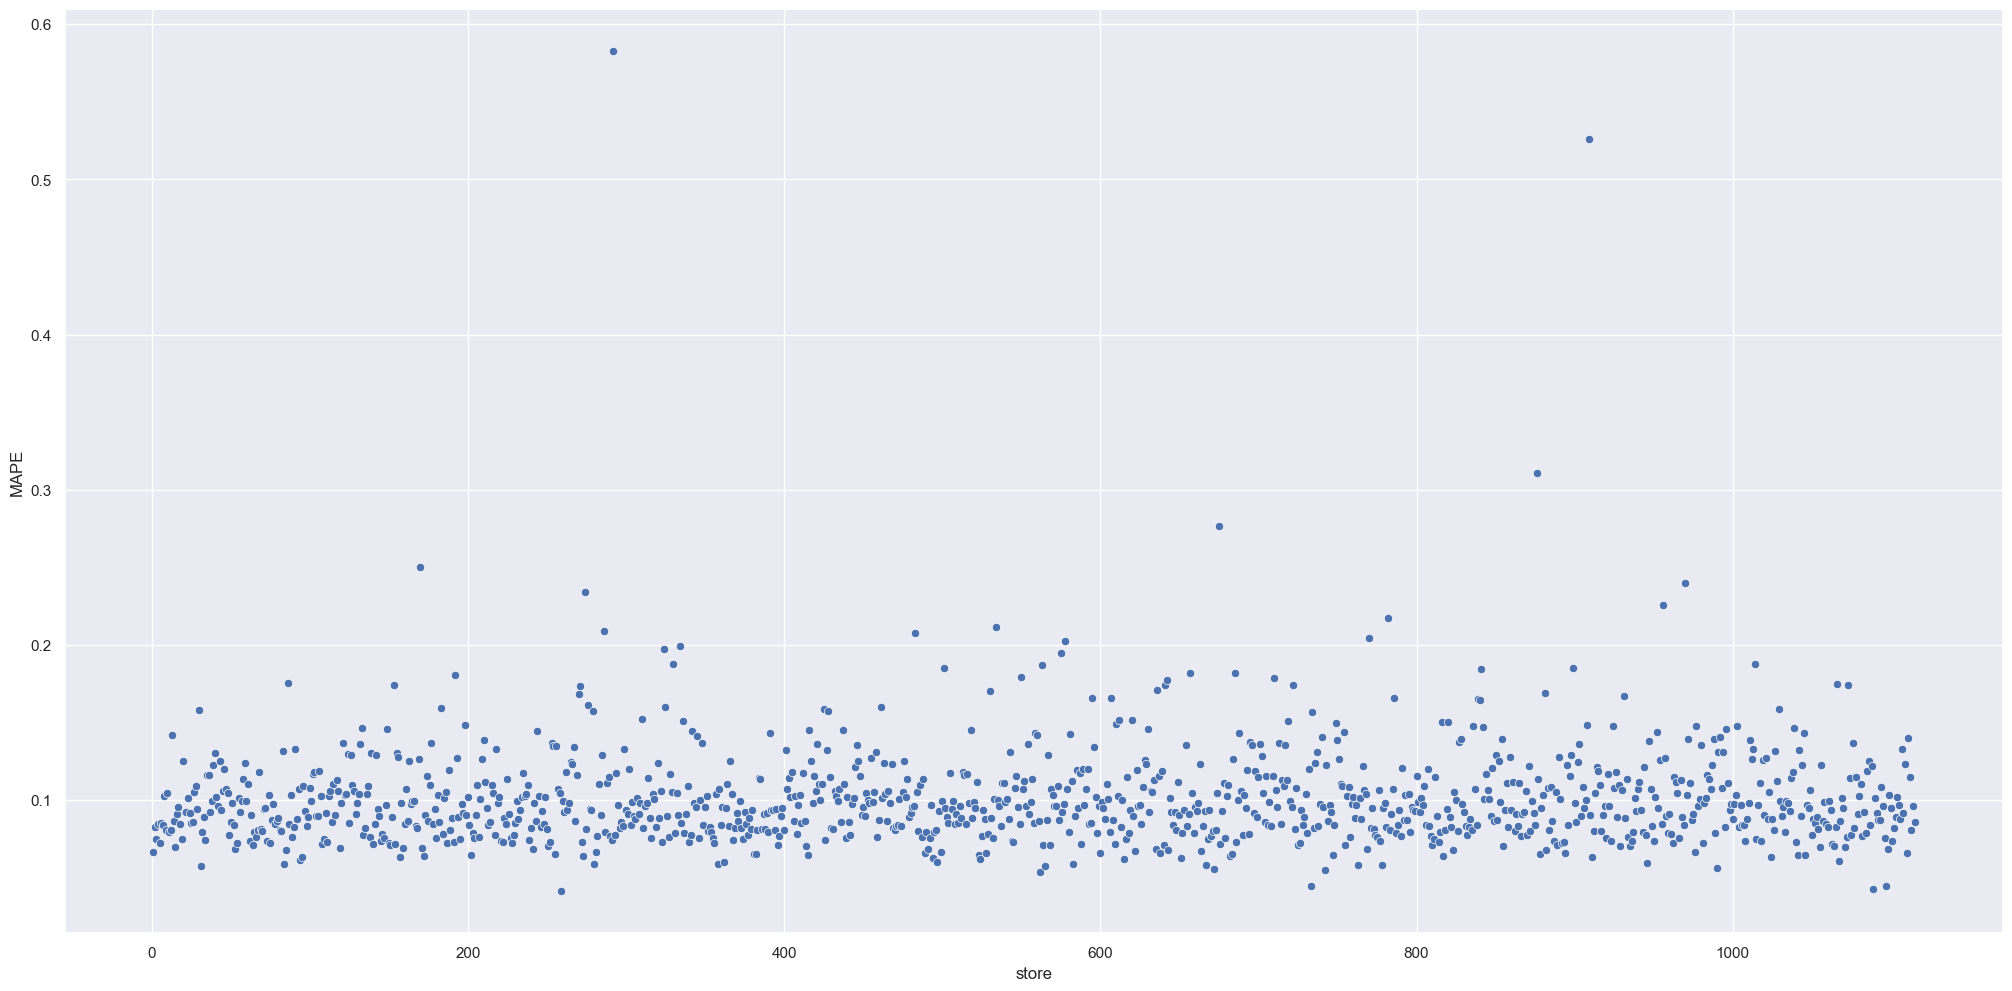

In [122]:
#Gráfico com todos os MAPES, mostra que tem lojas mais desafiadoras que as outras, mais que a maioria tem o MAPE baixo
sns.scatterplot(x='store',y='MAPE',data=df92);

# Total Performance

In [123]:
#Somando as colunas - Total de predições, melhor e pior cenário
df93 = df92[['predictions','worst_scenario','best_scenario']].apply(lambda x: np.sum(x),axis=0).reset_index().rename(columns={'index':'Scenario',0:'Values'})

#Colocando em reais
df93['Values'] = df93['Values'].map('R${:,.2f}'.format)
df93.head()

,Scenario,Values
0,predictions,"R$284,615,072.00"
1,worst_scenario,"R$283,844,721.87"
2,best_scenario,"R$285,385,428.41"


## 9.3 Machine Learning Performance

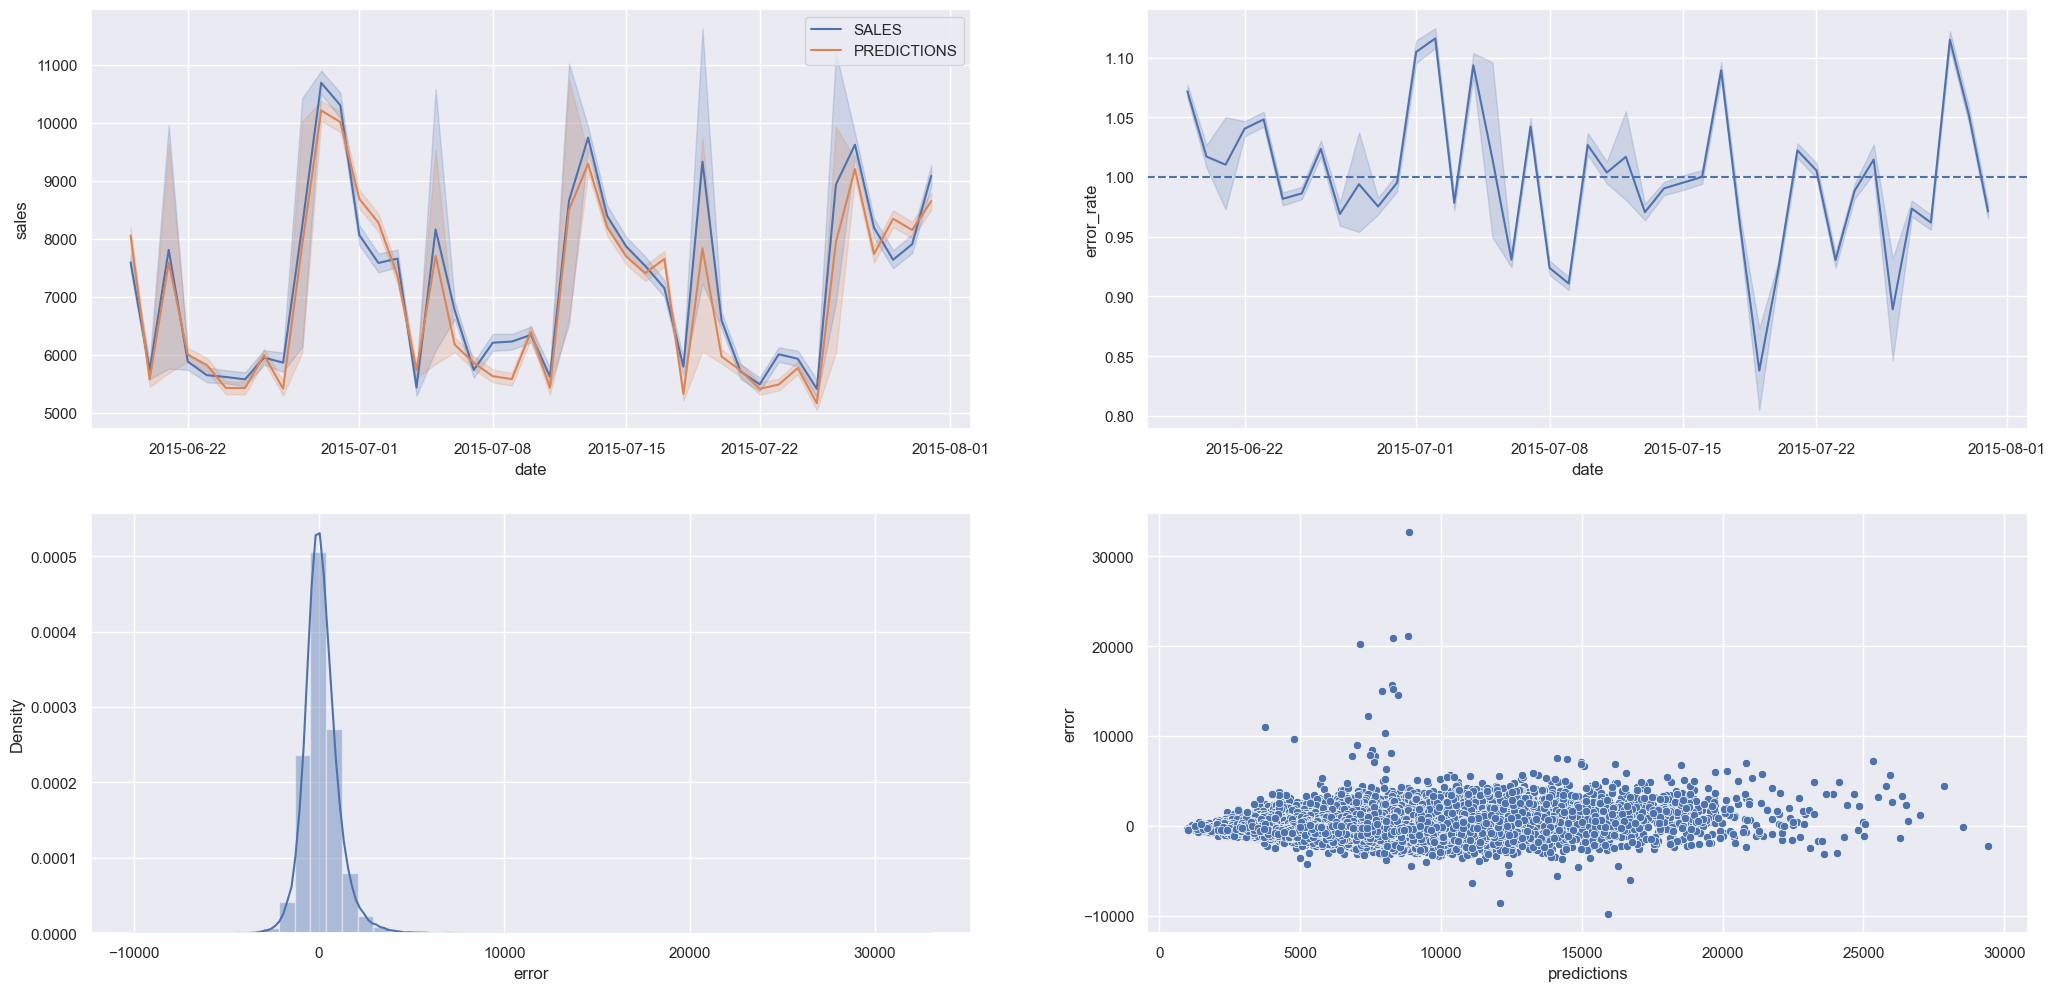

In [125]:
#Compara os valores de vendas com os valores preditos, para vermos o comportamento
plt.subplot(2,2,1)
sns.lineplot(x='date',y='sales',data=df9,label='SALES')
sns.lineplot(x='date',y='predictions',data=df9,label='PREDICTIONS');

#Comportamento da porcentagem das previsões em relação as vendas
#Consegue ver como está a superestimação e a subestimação
plt.subplot(2,2,2)
sns.lineplot(x='date',y='error_rate',data=df9);
plt.axhline(1,linestyle='--') #Linha tracejada no 1

#Comporamento do erro é uma distribuição normal
#Usado em análise do resíduo, usada para melhorar o modelo apontando os pontos fracos
plt.subplot(2,2,3)
sns.distplot(df9['error']);

#Predições com relação ao erro
#Podemos ver como o erro varia com o valor das predições e tentar perceber onde esse erro é mais crítico
#Erro preciso ficar dentro de um tubo, como está
plt.subplot(2,2,4)
sns.scatterplot(x='predictions',y='error',data=df9);

# <font color=blue>5. Próximos Passos</font>

- Workshop do Modelo para os usurários
- Coletar feedbacks sobre a Usabilidade
- Aumentar em 10% a Acuária do Modelo

# <font color=blue>Q & A</font>

# <font color=blue>Muito Obrigado!</font>